# <center> Building Lighting Intervention </center> 

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from IPython.core.debugger import set_trace

In [2]:
LABELS = ['so2_kg', 'nox_kg', 'pm25_kg', 'co2_kg', 'so2_dam_ap2', 'nox_dam_ap2',
       'pm25_dam_ap2', 'so2_dam_eas', 'nox_dam_eas', 'pm25_dam_eas',
       'co2_dam', 'dam_ap2', 'dam_eas']
LABELS.sort()
dam_cols_ap2 = ['co2_dam', 'so2_dam_ap2', 'nox_dam_ap2', 'pm25_dam_ap2']
dam_cols_eas = ['co2_dam', 'so2_dam_eas', 'nox_dam_eas', 'pm25_dam_eas']

In [3]:
GROUPING_NAMES = ['SeasonalTOD', 'MonthTOD', 'TOD', 'YearOnly', 'Month']
GROUPING_COLS = [['year', 'season', 'hour'], ['year', 'month', 'hour'], 
        ['year', 'hour'], ['year'], ['year', 'month']]
GROUPING_NAMES_COLS = dict(zip(GROUPING_NAMES, GROUPING_COLS))

## Read in data 

In [4]:
def get_factor_df(kind='MEF', time='MonthTOD', region='PJM', fuel_type='FossilOnly'):
    kind_folder = 'mefs' if kind=='MEF' else 'aefs'
    
    # Read in file
    if fuel_type == 'FossilOnly':
        region_breakdown = 'isorto' if region == 'PJM' else 'nerc'
        df = pd.read_csv(os.path.join(os.pardir, os.pardir, 'factor_estimates', 'calculated_factors', 
                                      kind_folder, time, 
                                      '{}_{}.csv'.format(region_breakdown, kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        df = df[df[region_breakdown] == region].drop(region_breakdown, axis=1)
    else:
        if region != 'PJM':
            raise NotImplementedError('fossil-plus factors are only available for PJM')
        df = pd.read_csv(os.path.join(os.pardir, os.pardir, 'factor_estimates', 'calculated_factors', 
                                      kind_folder, time, 
                                      'pjm_fplus_{}.csv'.format(kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        
    # Filter MEF columns
    if kind == 'MEF':
        df = df.drop([x for x in df.columns if '-r' in x or '-int' in x], axis=1)
        df.columns = [x.replace('-est', '') for x in df.columns]
        
    # Ensure columns have numeric type
    df = df.apply(pd.to_numeric, axis=1)
    
    return df

In [5]:
all_dfs = {}
for kind in ['MEF', 'AEF']:
    for region in ['PJM', 'RFC']:
        for fuel_type in ['FossilOnly', 'FossilPlus']:
            for time in ['YearOnly', 'Month', 'MonthTOD']:
#             for time in ['YearOnly', 'MonthTOD']:
                if region == 'RFC' and fuel_type == 'FossilPlus': 
                    continue
#                 print(kind, region, fuel_type, time)
                df = get_factor_df(kind=kind, time=time, region=region, fuel_type=fuel_type)
                all_dfs[(kind, region, fuel_type, time)] = df

## Construct intervention 

Intervention reduces electricity consumption by 100W from 8pm-midnight in 2017

In [6]:
HOURLY_REDUCTION_MWH = 100e-6
NUM_HOURS_PER_DAY = 4

In [7]:
hours2017 = pd.date_range('2017-01-01', '2018-01-01', freq='H', closed='left')
intervention_df = \
    pd.DataFrame(data=hours2017.map(lambda x: HOURLY_REDUCTION_MWH if x.hour in [20,21,22,23] else 0),
             index=hours2017, columns=['reduction_mwh'])

## Get intervention effects

In [8]:
def get_hour_factors(df, time, hours, prev_year=False):
    year_series = hours.map(lambda x: x.year-1) if prev_year else hours.map(lambda x: x.year)
    month_series = hours.map(lambda x: x.month)
    hour_series = hours.map(lambda x: x.hour)
    if time == 'YearOnly':
        df2 = df.loc[year_series]
    elif time == 'Month':
        df2 = df.loc[list(zip(year_series, month_series))]
    elif time == 'MonthTOD':
        df2 = df.loc[list(zip(year_series, month_series, hour_series))]
    df2 = df2.set_index(hours)
    return df2

In [9]:
# Get factor for each point in time series
hours2017_factors = {}
for key in all_dfs.keys():
#     print(key)
    df = all_dfs[key]
    
    # 2017
    df2 = get_hour_factors(df, key[-1], hours2017)
    hours2017_factors[key + (2017,)] = df2
    
    # 2016 for PJM fossil-plus
    if key[1] == 'PJM' and key[2] == 'FossilPlus':
        df3 = get_hour_factors(df, key[-1], hours2017, True)
        hours2017_factors[key + (2016,)] = df3

In [10]:
# Calculate effects
intervention_effects = {}
for key in hours2017_factors.keys():
    reds = hours2017_factors[key].multiply(intervention_df['reduction_mwh'], axis='index')
    effects = reds[LABELS].sum()  # total effect
    
    # For MEFs, propagate error. 
    #   When same factor is applied to multiple reductions 
    #      (i.e. multiplied by their total reduction amount), this factor's SE should be summed across
    #      these reductions (i.e. also multiplied by the total reduction amount).
    #   Independent errors (from different factors) should then be combined by the sqrt of their
    #      sum of squares.
    if key[0] == 'MEF':
        
        # Per-factor (non-independent) errors
        groupby_list = dict([('YearOnly', reds.index.year), 
                             ('Month', [reds.index.year, reds.index.month]),
                             ('MonthTOD', [reds.index.year, reds.index.month, reds.index.hour])])
        per_factor_errors = reds[['{}-se'.format(x) for x in LABELS]].groupby(
            groupby_list[key[-2]]).sum()
        
        # Combine per-factor errors to get independent errors
        ses = np.sqrt((per_factor_errors ** 2).sum())
#         ses = np.sqrt((reds[['{}-se'.format(x) for x in LABELS]] ** 2).sum())

        effects = pd.concat([effects, ses])
    intervention_effects[key] = effects

In [11]:
intervention_effects_df = pd.DataFrame(intervention_effects).T
intervention_effects_df.index.names = ['kind', 'region', 'fuel_type', 'time', 'year']

## Some analysis 

In [12]:
def get_summary(intervention_effects_df, pollutant):
    poll_effect = intervention_effects_df[pollutant]
    print('Min: {}, {}'.format(poll_effect.min(), poll_effect.idxmin()))
    print('Max: {}, {}'.format(poll_effect.max(), poll_effect.idxmax()))
    print(poll_effect.T)
    return poll_effect.T

In [13]:
df = get_summary(intervention_effects_df, 'dam_eas')

Min: 4.350053539893894, ('AEF', 'PJM', 'FossilPlus', 'Month', 2017)
Max: 9.641871757078029, ('MEF', 'PJM', 'FossilPlus', 'MonthTOD', 2016)
kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017    7.473563
                          MonthTOD  2017    7.516073
                          YearOnly  2017    7.475013
              FossilPlus  Month     2016    4.918651
                                    2017    4.350054
                          MonthTOD  2016    4.960780
                                    2017    4.391716
                          YearOnly  2016    4.969516
                                    2017    4.362391
      RFC     FossilOnly  Month     2017    8.577665
                          MonthTOD  2017    8.651410
                          YearOnly  2017    8.576835
MEF   PJM     FossilOnly  Month     2017    7.674931
                          MonthTOD  2017    7.653612
                          YearOnly  2017    7.713988
              FossilPlus 

In [14]:
((df / df.loc[('MEF', 'PJM', 'FossilPlus', 'MonthTOD', 2017)])*100).round(0).astype(int)

kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017    101
                          MonthTOD  2017    101
                          YearOnly  2017    101
              FossilPlus  Month     2016     66
                                    2017     59
                          MonthTOD  2016     67
                                    2017     59
                          YearOnly  2016     67
                                    2017     59
      RFC     FossilOnly  Month     2017    116
                          MonthTOD  2017    117
                          YearOnly  2017    116
MEF   PJM     FossilOnly  Month     2017    104
                          MonthTOD  2017    103
                          YearOnly  2017    104
              FossilPlus  Month     2016    124
                                    2017    103
                          MonthTOD  2016    130
                                    2017    100
                          YearOnly  2016    122

In [15]:
((df / df.loc[('MEF', 'PJM', 'FossilOnly', 'MonthTOD', 2017)])*100).round(0).astype(int)

kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017     98
                          MonthTOD  2017     98
                          YearOnly  2017     98
              FossilPlus  Month     2016     64
                                    2017     57
                          MonthTOD  2016     65
                                    2017     57
                          YearOnly  2016     65
                                    2017     57
      RFC     FossilOnly  Month     2017    112
                          MonthTOD  2017    113
                          YearOnly  2017    112
MEF   PJM     FossilOnly  Month     2017    100
                          MonthTOD  2017    100
                          YearOnly  2017    101
              FossilPlus  Month     2016    120
                                    2017    100
                          MonthTOD  2016    126
                                    2017     97
                          YearOnly  2016    118

In [16]:
df = get_summary(intervention_effects_df, 'dam_ap2')

Min: 4.791898349867585, ('AEF', 'PJM', 'FossilPlus', 'Month', 2017)
Max: 11.832876146637044, ('MEF', 'PJM', 'FossilPlus', 'MonthTOD', 2016)
kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017     8.231717
                          MonthTOD  2017     8.256709
                          YearOnly  2017     8.236968
              FossilPlus  Month     2016     5.631765
                                    2017     4.791898
                          MonthTOD  2016     5.669619
                                    2017     4.825923
                          YearOnly  2016     5.701256
                                    2017     4.807065
      RFC     FossilOnly  Month     2017     9.078786
                          MonthTOD  2017     9.117362
                          YearOnly  2017     9.082103
MEF   PJM     FossilOnly  Month     2017     8.884841
                          MonthTOD  2017     9.079928
                          YearOnly  2017     8.946238
         

In [17]:
((df / df.loc[('MEF', 'PJM', 'FossilPlus', 'MonthTOD', 2017)])*100).round(0).astype(int)

kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017     94
                          MonthTOD  2017     94
                          YearOnly  2017     94
              FossilPlus  Month     2016     64
                                    2017     55
                          MonthTOD  2016     64
                                    2017     55
                          YearOnly  2016     65
                                    2017     55
      RFC     FossilOnly  Month     2017    103
                          MonthTOD  2017    104
                          YearOnly  2017    103
MEF   PJM     FossilOnly  Month     2017    101
                          MonthTOD  2017    103
                          YearOnly  2017    102
              FossilPlus  Month     2016    126
                                    2017    101
                          MonthTOD  2016    135
                                    2017    100
                          YearOnly  2016    125

In [18]:
((df / df.loc[('MEF', 'PJM', 'FossilOnly', 'MonthTOD', 2017)])*100).round(0).astype(int)

kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017     91
                          MonthTOD  2017     91
                          YearOnly  2017     91
              FossilPlus  Month     2016     62
                                    2017     53
                          MonthTOD  2016     62
                                    2017     53
                          YearOnly  2016     63
                                    2017     53
      RFC     FossilOnly  Month     2017    100
                          MonthTOD  2017    100
                          YearOnly  2017    100
MEF   PJM     FossilOnly  Month     2017     98
                          MonthTOD  2017    100
                          YearOnly  2017     99
              FossilPlus  Month     2016    122
                                    2017     98
                          MonthTOD  2016    130
                                    2017     97
                          YearOnly  2016    121

## Bar plots for SI

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def get_dam_name(dam_abbr):
    return 'AP2' if dam_abbr == 'ap2' else 'EASIUR'
    
FULL_DAMS = ['dam_ap2', 'dam_eas']
def format_title(label):
    l = label.split('_')
    if label in FULL_DAMS:
        t = 'Total damages ({})'.format('AP2' if l[1] == 'ap2' else 'EASIUR')
    else:
        t = '{0}$_{{{1}}}$ {2}'.format(l[0][:2].upper(), l[0][2:], 'emissions' if l[1] == 'kg' else 'damages')
        if len(l) > 2: t += ' ({})'.format('AP2' if l[2] == 'ap2' else 'EASIUR')
    return t

def format_axis(label):
    l = label.split('_')
    if label in FULL_DAMS:
        t = 'Total damages\navoided ($)'
    elif len(l) > 2 or l[1] == 'dam':
        t = 'Damages\navoided ($)'
    else:
        t = 'Emissions\navoided (kg)'
    return t

In [21]:
# Get formatted df with intervention effects for given label
def get_onelabel_formatted(label):
    kind_map = dict([('MEF', 'Marginal'), ('AEF', 'Average')])
    time_map = dict([('YearOnly', 'Annual'), ('MonthTOD', 'Monthly TOD'), ('Month', 'Monthly')])
    
    df = intervention_effects_df[label].reset_index()
    df['spat'] = df.apply(
        lambda x: '{} ({}-{}{})'.format(
            x['region'], x['fuel_type'][:-4].lower(), x['fuel_type'][-4:].lower(), 
            ' 2016' if x['year'] == 2016 else ''), axis=1)
    df['spat'] = df['spat'].str.replace('fossil-plus', 'fossil+non-emit')
    df = df.drop(['region', 'fuel_type', 'year'], axis=1)
    df['kind'] = df['kind'].map(lambda x: kind_map[x]).astype(
        pd.CategoricalDtype(categories=['Marginal', 'Average'], ordered=True))
    df['time'] = df['time'].map(lambda x: time_map[x]).astype(
        pd.CategoricalDtype(categories=['Annual', 'Monthly', 'Monthly TOD'], ordered=True))
    df['spat'] = df['spat'].astype(pd.CategoricalDtype(
        categories=['PJM (fossil-only)', 'PJM (fossil+non-emit 2016)', 'PJM (fossil+non-emit)', 'RFC (fossil-only)'], 
        ordered=True))
    df = df.sort_values(['spat', 'kind', 'time'])
    
    return df

In [22]:
def get_stacked_plot(label):
    df = get_onelabel_formatted(label)
    df_se = get_onelabel_formatted('{}-se'.format(label))
    
    # Get bar plot
    sns.set(style="whitegrid")
    g = sns.catplot(x='kind', y=label, hue='time', col='spat', data=df,
                       kind='bar', palette=[sns.color_palette('muted')[x] for x in [0,2,3]], legend=False, ci=None,
                       height=3, aspect=1).set_titles('{col_name}')
    g.despine(left=True);
    
    # Adjust font size and add legend
    fontsize=18
    for i, ax in enumerate(g.axes.flatten()):
        ax.set_xlabel('')
        for item in ([#ax.title, 
                      ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
        ax.title.set_fontsize(fontsize-2)

        if i == 0:
            lgd = ax.legend(loc='center left', bbox_to_anchor=(0.75, -0.3), ncol=3, frameon=True, fontsize=fontsize)
            ax.set_ylabel(format_axis(label))
            
        # Annotate baseline -- PJM fossil-plus marginal monthly TOD
        if i == 2:
            baseline_x = 0.27
            patch_width = [p.get_width() for p in ax.patches][0]
            baseline_y = max([p.get_height() \
                          for p in ax.patches if abs(p.get_xy()[0]+patch_width/2-baseline_x)<=patch_width/4])
            ax.text(s='*', x=baseline_x, y=1.05 * baseline_y,
                   horizontalalignment='center', verticalalignment='center', 
                    fontsize=fontsize*2, fontweight='bold')
    
    # Hacky errorbars
    for i, ax in enumerate(g.axes[0]):
        spat = df['spat'].dtype.categories[i]
        df_slice = df.query('spat == @spat').query('kind == "Marginal"')
        df_se_slice = df_se.query('spat == @spat').query('kind == "Marginal"')
        ax.errorbar([-0.27,0, 0.27], df_slice[label].values,
                        yerr=df_se_slice['{}-se'.format(label)].values, ms=20, color='black', 
                        linewidth=0, elinewidth=2, capsize=2, capthick=2)
        
    # Plot title
    fig = plt.gcf()
#     sup=fig.text(0.5, 1, format_title(label), 
#              fontsize=fontsize, fontweight='bold', fontstyle='italic',
#             transform=fig.transFigure, ha='center')
    
    plt.tight_layout()
    
#     dirname = os.path.join('plots', 'building_lighting')
#     if not os.path.exists(dirname): os.makedirs(dirname)
#     g.fig.savefig(os.path.join(dirname, 'si-{}-withmonth.pdf'.format(label)),
#                  bbox_extra_artists=(lgd,), #(lgd,sup), 
#                   bbox_inches='tight')

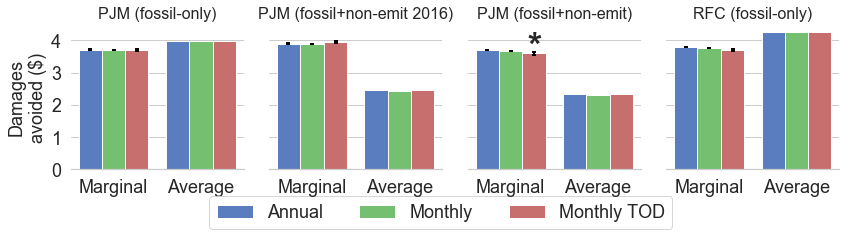

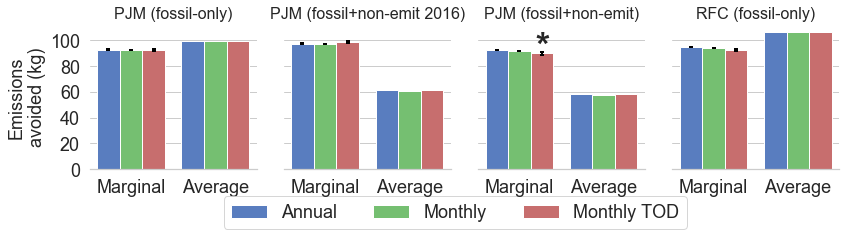

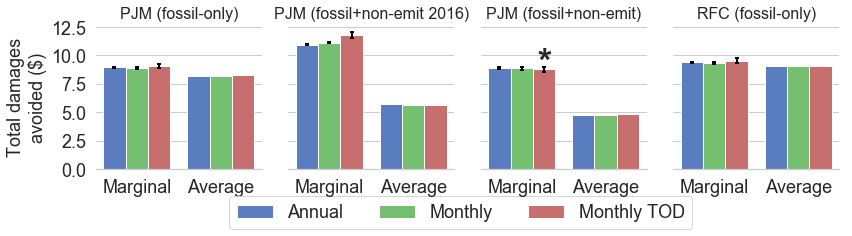

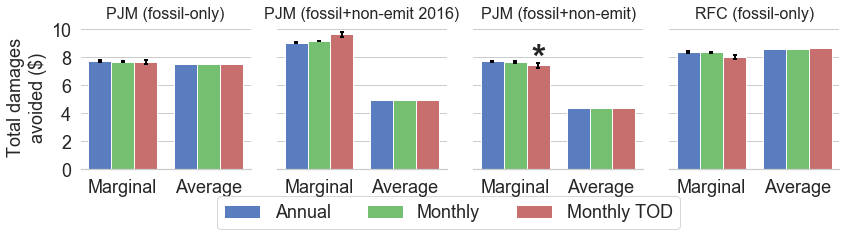

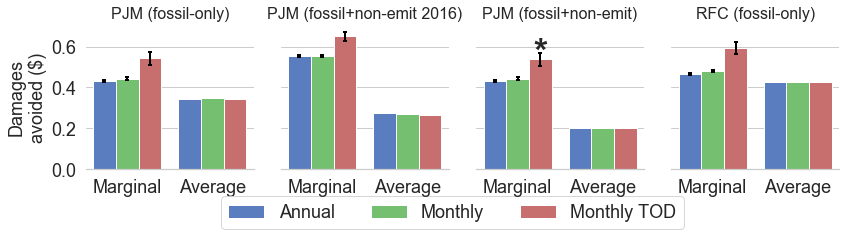

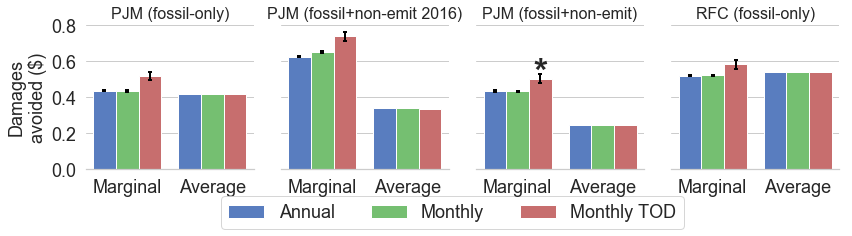

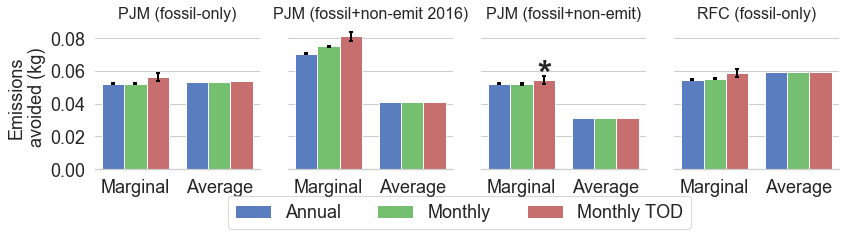

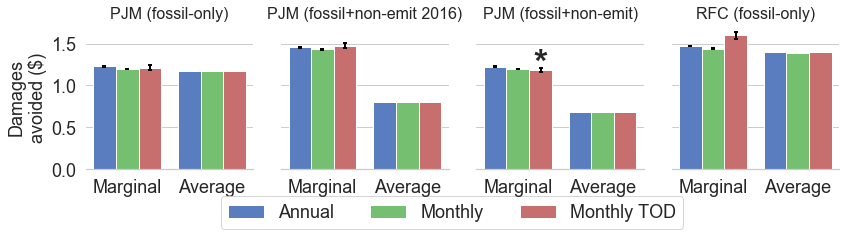

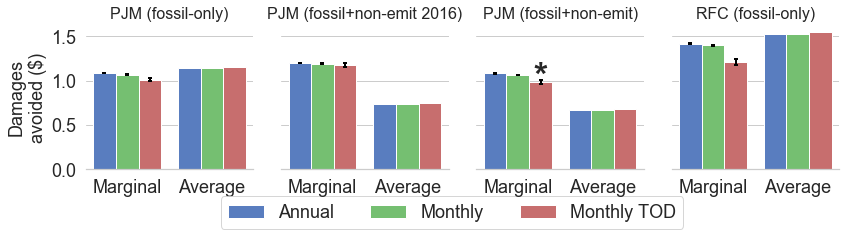

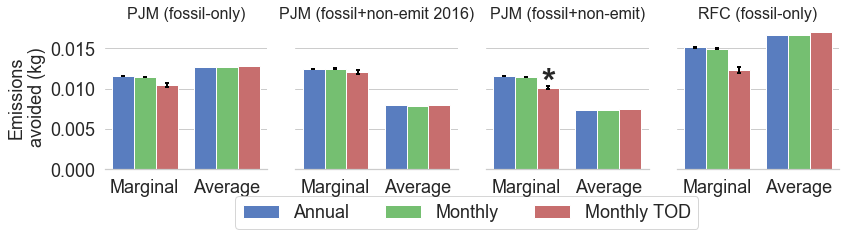

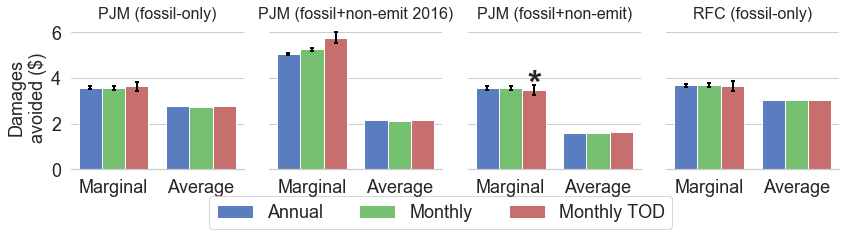

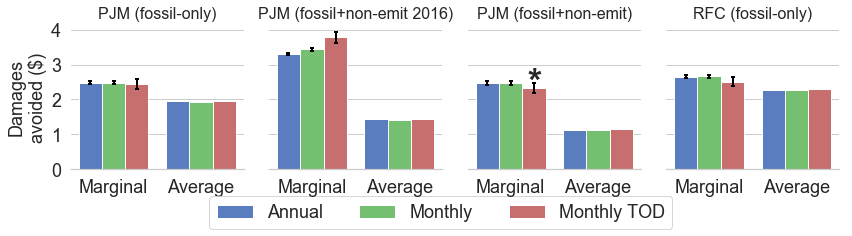

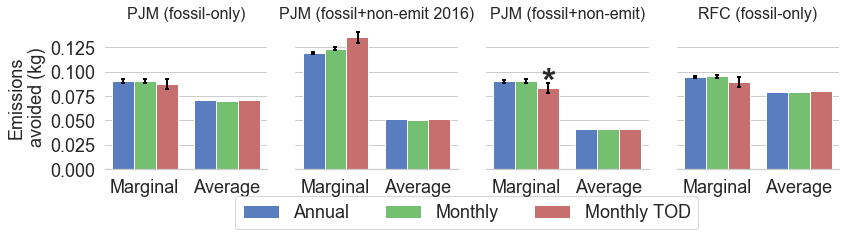

In [23]:
for label in LABELS:
    get_stacked_plot(label)

## Stacked bar plots for total damages 

In [24]:
import matplotlib.patches as mpatches

In [25]:
def plot_total_damages(dam_type, title=False):
    
    fontsize=18
    
    plt.rcParams['hatch.linewidth'] = 0.5
    sns.set(style="whitegrid", color_codes=True)

    dam_cols = dam_cols_eas if dam_type == 'EASIUR' else dam_cols_ap2
    se_col = 'dam_{}-se'.format('eas' if dam_type == 'EASIUR' else 'ap2')

    df = get_onelabel_formatted(dam_cols)
    df = (df.set_index(['spat', 'kind', 'time'])).reset_index()
    
    df_cum = df.set_index(['spat', 'kind', 'time']).cumsum(axis=1).reset_index()

    # Stacked bar plot
    g = sns.FacetGrid(data=df_cum, col='spat', size=3, aspect=1)
    hatches = ['||', '///', '', '\\\\\\']

    g.map(sns.barplot, 'kind', dam_cols[-1], 'time', 
          hue_order=['Annual', 'Monthly', 'Monthly TOD'], order=['Marginal', 'Average'],
          palette=[sns.color_palette('muted')[x] for x in [0,2,3]], edgecolor='black', hatch=hatches[0])  
    g.map(sns.barplot, 'kind', dam_cols[-2], 'time', 
          hue_order=['Annual', 'Monthly', 'Monthly TOD'], order=['Marginal', 'Average'],
          palette=[sns.color_palette('muted')[x] for x in [0,2,3]], edgecolor='black', hatch=hatches[1])
    g.map(sns.barplot, 'kind', dam_cols[-3], 'time', 
          hue_order=['Annual', 'Monthly', 'Monthly TOD'], order=['Marginal', 'Average'],
          palette=[sns.color_palette('muted')[x] for x in [0,2,3]], edgecolor='black', hatch=hatches[2])
    g.map(sns.barplot, 'kind', dam_cols[-4], 'time', 
          hue_order=['Annual', 'Monthly', 'Monthly TOD'], order=['Marginal', 'Average'],
          palette=[sns.color_palette('muted')[x] for x in [0,2,3]], edgecolor='black', hatch=hatches[3]).set_titles('{col_name}')
    g.despine(left='true')

    # Legend, fontsize, and other formatting
    xoffset=0.035

    for i, ax in enumerate(g.axes.flatten()):

        ax.set_xlabel('') # No x-label

        if i == 0:
            # y label on left plot
            ax.set_ylabel('Total damages\navoided (\$)'.format(dam_type))

            # pollutants legend
            leg_dict = dict(zip(dam_cols, ['CO$_2$', 'SO$_2$', 'NO$_x$', 'PM$_{{2.5}}$']))
            dam_patches = []
            for dam, hatch in zip(dam_cols, hatches[::-1]):
                patch = mpatches.Patch(facecolor='white', label=leg_dict[dam], edgecolor='black', hatch=hatch)
                dam_patches.append(patch)

            lgd = ax.legend(handles=dam_patches, loc='center left', 
                            bbox_to_anchor=(0.3+xoffset, -0.15), ncol=4, frameon=True, fontsize=fontsize,
                            bbox_transform=plt.gcf().transFigure)
            plt.text(0.16+xoffset, -0.175, 'Pollutants:', transform=plt.gcf().transFigure,
                     fontsize=fontsize, fontweight='bold')
            lgd.get_frame().set_edgecolor('white')


        if i == 1:

            # temporal scope legend (same length as pollutants legend for alignment)
            blank_patch = mpatches.Patch(color='white', label='')
            ann_patch = mpatches.Patch(color=sns.color_palette('muted')[0], label='Annual', edgecolor='black')
            month_patch = mpatches.Patch(color=sns.color_palette('muted')[2], label='Monthly', edgecolor='black')
            tod_patch = mpatches.Patch(color=sns.color_palette('muted')[3], label='Monthly TOD', edgecolor='black')
            time_patches = [blank_patch, ann_patch, month_patch, tod_patch, blank_patch]
            lgd2 = ax.legend(handles=time_patches, loc='center left', 
                            bbox_to_anchor=(0.19+xoffset, -0.025), ncol=5, frameon=True, fontsize=fontsize,
                            bbox_transform=plt.gcf().transFigure)
            plt.text(0.09+xoffset, -0.045, 'Temporal scopes:', transform=plt.gcf().transFigure, 
                     fontsize=fontsize, fontweight='bold')
            lgd2.get_frame().set_edgecolor('white')
            
        # Annotate baseline -- PJM fossil-plus marginal monthly TOD
        if i == 2:
            baseline_x = 0.27
            patch_width = [p.get_width() for p in ax.patches][0]
            baseline_y = max([p.get_height() \
                          for p in ax.patches if abs(p.get_xy()[0]+patch_width/2-baseline_x)<=patch_width/4])
            ax.text(s='*', x=baseline_x, y=1.05 * baseline_y,
                   horizontalalignment='center', verticalalignment='center', 
                    fontsize=fontsize*2, fontweight='bold')
            
        # Set font size
        for item in ([
#             ax.title, 
            ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
        ax.title.set_fontsize(fontsize-2)


    # Hacky errorbars
    df_tot = get_onelabel_formatted(se_col[:-3])
    df_tot_se = get_onelabel_formatted(se_col)
    for i, ax in enumerate(g.axes[0]):
        spat = df_tot['spat'].dtype.categories[i]
        df_tot_slice = df_tot.query('spat == @spat').query('kind == "Marginal"')
        df_tot_se_slice = df_tot_se.query('spat == @spat').query('kind == "Marginal"')
        ax.errorbar([-0.27, 0,0.27], df_tot_slice[se_col[:-3]].values,
                        yerr=df_tot_se_slice[se_col].values, ms=20, color='black', 
                        linewidth=0, elinewidth=2, capsize=2, capthick=2)   

    # Line around legend
    fig = plt.gcf()
    leg_line = \
        mpatches.Rectangle(
            (0.073+xoffset, -0.2), 0.8, 0.24, facecolor='none', edgecolor='lightgray', 
            transform=fig.transFigure, figure=fig)
    fig.patches.extend([leg_line])

    extra_artists = (lgd, lgd2)
    if title:
        sup=fig.text(0.5, 0.9, 'Total damages ({})\n'.format(dam_type), 
                         fontsize=fontsize, fontweight='bold', fontstyle='italic',
                        transform=fig.transFigure, ha='center')
        extra_artists = extra_artists + (sup,)

    plt.tight_layout()
#     dirname = os.path.join('plots', 'building_lighting')
#     if not os.path.exists(dirname): os.makedirs(dirname)
#     g.fig.savefig(os.path.join(dirname, 
#                                '{}-stacked-with-error{}-withmonth.pdf'.format(dam_type, '-titled' if title else '')),
#                  bbox_extra_artists=extra_artists, bbox_inches='tight')

/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


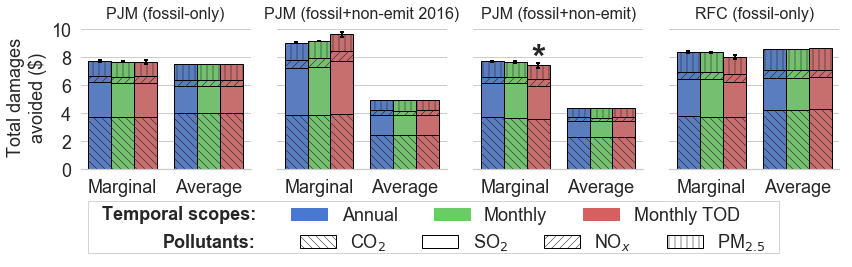

In [26]:
plot_total_damages('EASIUR', title=False)

/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


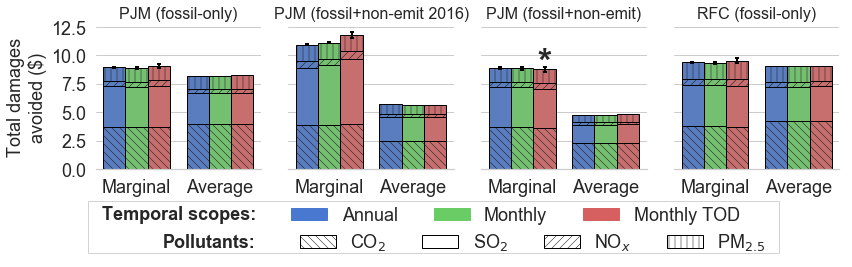

In [27]:
plot_total_damages('AP2', title=False)